In [1]:
using Revise
using Kinetic
using Flux
using DifferentialEquations
using DiffEqFlux
using Optim
using Plots

config = "../src/homogeneous/config.txt"
println("Reading settings from $config \n")

# generate parameters
D = read_dict(config)
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

dim = ifelse(parse(Int, space[3]) >= 3, 3, parse(Int, space[1]))
γ = 1.4#heat_capacity_ratio(inK, dim)
vSpace = VSpace1D(u0, u1, nu, vMeshType, nug)

f0 = Float32.(0.3 * vSpace.u.^2 .* exp.(-0.3 .* vSpace.u.^2)) |> Array
w0 = [ discrete_moments(f0, vSpace.u, vSpace.weights, 0), 
       discrete_moments(f0, vSpace.u, vSpace.weights, 1), 
       discrete_moments(f0, vSpace.u, vSpace.weights, 2) ]
prim0 = conserve_prim(w0, γ)

M = Float32.(maxwellian(vSpace.u, prim0)) |> Array

f = similar(M)

Reading settings from ../src/homogeneous/config.txt 

case = homogeneous
space = 1d1f
cfl = 0.5
maxTime = 5
u0 = -7
u1 = 7
nu = 41
vMeshType = newton
nug = 0
knudsen = 1
inK = 0



41-element Array{Float32,1}:
  1.6870144e7 
  4.5664e-41  
  0.0         
  0.0         
  1.3879984e7 
  4.5664e-41  
  1.4182224e7 
  4.5664e-41  
  0.0         
  0.0         
  1.3879984e7 
  4.5664e-41  
  1.3861584e7 
  ⋮           
  4.5664e-41  
  1.4182224e7 
  4.5664e-41  
  0.0         
  0.0         
  1.3879984e7 
  4.5664e-41  
  1.3861584e7 
  4.5664e-41  
  0.0         
  0.0         
 -3.0553238e15

In [28]:
function collision!(du, u, p, t)
    du .= p .- u
end

tspan = (0.0, maxTime)
tRange = range(tspan[1], tspan[2], length=5)
prob = ODEProblem(collision!, f0, tspan, M)
sol = solve(prob, Tsit5(), saveat=tRange)
ode_data = Array(sol)

41×5 Array{Float32,2}:
 1.17318e-5   6.17217e-6   4.57933e-6   4.12293e-6   3.99224e-6 
 4.14257e-5   2.06303e-5   1.46724e-5   1.29653e-5   1.24764e-5 
 0.000135639  6.46244e-5   4.42786e-5   3.84488e-5   3.67794e-5 
 0.000411559  0.000189378  0.000125723  0.000107484  0.000102261
 0.00115634   0.000518307  0.00033551   0.000283132  0.000268133
 0.00300578   0.00132283   0.000840659  0.000702501  0.000662938
 0.00722068   0.00314387   0.00197586   0.00164118   0.00154534 
 0.0160093    0.00694867   0.00435279   0.00360899   0.00339599 
 0.0327062    0.0142656    0.00898234   0.00746851   0.007035   
 0.0614401    0.0271735    0.017356     0.014543     0.0137375  
 0.105848     0.047978     0.0313981    0.0266475    0.025287   
 0.166649     0.0784592    0.0531928    0.0459532    0.04388    
 0.238643     0.118786     0.0844467    0.0746074    0.0717897  
 ⋮                                                              
 0.166649     0.0784592    0.0531928    0.0459532    0.04388    
 0

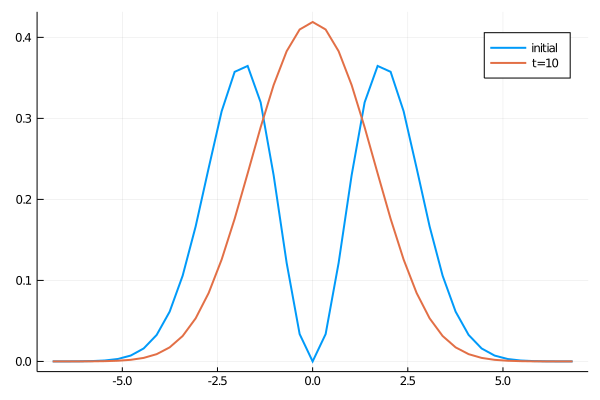

In [29]:
plot(vSpace.u, f0, lw=2, label="initial")
plot!(vSpace.u, sol.u[3], lw=2, label="t=10")

In [32]:
dudt = FastChain( (x, p) -> x.^2 / 2,
                   FastDense(41,300,tanh),
                   FastDense(300,41) )
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat=tRange)

(::NeuralODE{FastChain{Tuple{var"#20#21",FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#75"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#75"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float64,Int64},Tsit5,Tuple{},Base.Iterators.Pairs{Symbol,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Tuple{Symbol},NamedTuple{(:saveat,),Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}}}) (generic function with 4 methods)

In [38]:
function predict_n_ode(u0, p)
    n_ode(u0, p)
end

function loss_n_ode(p)
    pred = predict_n_ode(f0, p)
    loss = sum(abs2, pred .- ode_data)
    return loss, pred
end

loss_n_ode(n_ode.p) # n_ode.p stores the initial parameters of the neural ODE

(4.0917864f0, t: [0.0, 1.25, 2.5, 3.75, 5.0]
u: Array{Float32,1}[[1.1731778e-5, 4.142575e-5, 0.00013563911, 0.00041155893, 0.0011563409, 0.003005783, 0.0072206757, 0.01600931, 0.032706194, 0.06144011  …  0.06144011, 0.032706194, 0.01600931, 0.0072206757, 0.003005783, 0.0011563409, 0.00041155893, 0.00013563911, 4.142575e-5, 1.1731778e-5], [0.021321513, 0.008270265, 0.00023950703, -0.002669438, -0.009469145, -0.022606196, 0.0014517792, 0.020490848, 0.024673028, 0.0544046  …  0.021375958, 0.05554599, 0.037175294, 0.018460372, 0.020047156, -0.01761038, 0.032607693, 0.029672252, 0.008486098, 0.031398945], [0.039973766, 0.011805838, 0.0013773305, -0.007496209, -0.018770859, -0.050230663, -0.004782566, 0.029388841, 0.012755656, 0.04576336  …  -0.02175803, 0.08142249, 0.059281137, 0.033921197, 0.035055462, -0.038432844, 0.06281997, 0.05507377, 0.01850093, 0.0617308], [0.056966994, 0.010324476, 0.0035082318, -0.014466289, -0.026954852, -0.07964026, -0.01159417, 0.042503685, -0.004021046, 0.0365

(4.0917864f0, t: [0.0, 1.25, 2.5, 3.75, 5.0]
u: Array{Float32,1}[[1.1731778e-5, 4.142575e-5, 0.00013563911, 0.00041155893, 0.0011563409, 0.003005783, 0.0072206757, 0.01600931, 0.032706194, 0.06144011  …  0.06144011, 0.032706194, 0.01600931, 0.0072206757, 0.003005783, 0.0011563409, 0.00041155893, 0.00013563911, 4.142575e-5, 1.1731778e-5], [0.021321513, 0.008270265, 0.00023950703, -0.002669438, -0.009469145, -0.022606196, 0.0014517792, 0.020490848, 0.024673028, 0.0544046  …  0.021375958, 0.05554599, 0.037175294, 0.018460372, 0.020047156, -0.01761038, 0.032607693, 0.029672252, 0.008486098, 0.031398945], [0.039973766, 0.011805838, 0.0013773305, -0.007496209, -0.018770859, -0.050230663, -0.004782566, 0.029388841, 0.012755656, 0.04576336  …  -0.02175803, 0.08142249, 0.059281137, 0.033921197, 0.035055462, -0.038432844, 0.06281997, 0.05507377, 0.01850093, 0.0617308], [0.056966994, 0.010324476, 0.0035082318, -0.014466289, -0.026954852, -0.07964026, -0.01159417, 0.042503685, -0.004021046, 0.0365

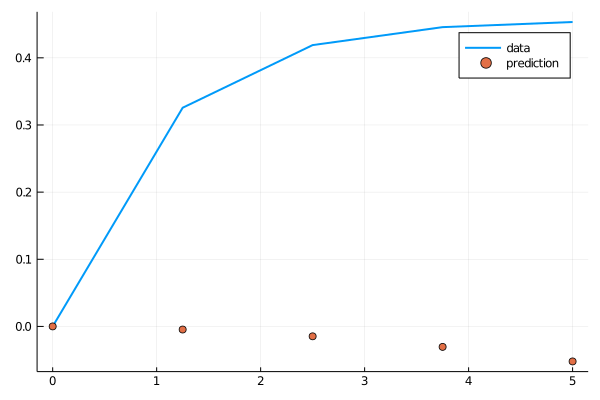

false

In [39]:
cb = function (p,l,pred;doplot=false) #callback function to observe training
    display(l)
    # plot current prediction against data
    if doplot
        pl = plot(tRange, ode_data[21,:], lw=2, label="data")
        scatter!(pl, tRange, pred[21,:], label="prediction")
        display(plot(pl))
    end
    return false
end

# Display the ODE with the initial parameter values.
cb(n_ode.p, loss_n_ode(n_ode.p), predict_n_ode(f0, n_ode.p), doplot=true)

In [40]:
res = DiffEqFlux.sciml_train(loss_n_ode, n_ode.p, ADAM(), cb=cb, maxiters=200)

4.0917864f0

loss: 4.09:   0%|▎                                        |  ETA: 0:00:48

2.861204f0

2.0242102f0

loss: 2.02:   2%|▋                                        |  ETA: 0:00:25

1.4314694f0

1.0128188f0

loss: 1.01:   2%|█                                        |  ETA: 0:00:20

0.72926724f0

0.5537492f0

loss: 0.554:   4%|█▍                                       |  ETA: 0:00:18

0.4613758f0

0.42556822f0

loss: 0.426:   4%|█▉                                       |  ETA: 0:00:16

0.42046845f0

0.42915666f0

loss: 0.429:   6%|██▎                                      |  ETA: 0:00:15

0.44220737f0

0.44953182f0

loss: 0.45:   6%|██▋                                      |  ETA: 0:00:15

0.4421214f0

0.41828772f0

loss: 0.418:   8%|███▏                                     |  ETA: 0:00:14

0.38303423f0

0.343184f0

loss: 0.343:   8%|███▌                                     |  ETA: 0:00:14

0.30418003f0

0.26935574f0

loss: 0.269:  10%|███▉                                     |  ETA: 0:00:13

0.24040847f0

0.21802059f0

loss: 0.218:  10%|████▎                                    |  ETA: 0:00:13

0.20207033f0

0.19154185f0

loss: 0.192:  12%|████▊                                    |  ETA: 0:00:13

0.18463312f0

0.1793902f0

loss: 0.179:  12%|█████▏                                   |  ETA: 0:00:12

0.17453332f0

0.1697683f0

loss: 0.17:  14%|█████▌                                   |  ETA: 0:00:12

0.16537735f0

0.16159067f0

loss: 0.162:  14%|██████                                   |  ETA: 0:00:12

0.15825976f0

0.15492578f0

loss: 0.155:  16%|██████▍                                  |  ETA: 0:00:12

0.15107025f0

0.14632937f0

loss: 0.146:  16%|██████▊                                  |  ETA: 0:00:11

0.14060228f0

0.1340452f0

loss: 0.134:  18%|███████▏                                 |  ETA: 0:00:11

0.12697297f0

0.11974965f0

loss: 0.12:  18%|███████▋                                 |  ETA: 0:00:11

0.11273954f0

0.10628653f0

loss: 0.106:  20%|████████                                 |  ETA: 0:00:11

0.10064855f0

0.095903285f0

loss: 0.0959:  20%|████████▍                                |  ETA: 0:00:11

0.09192813f0

0.08848944f0

loss: 0.0885:  22%|████████▉                                |  ETA: 0:00:10

0.08536107f0

0.08238852f0

loss: 0.0824:  22%|█████████▎                               |  ETA: 0:00:10

0.07949583f0

0.07666861f0

loss: 0.0767:  24%|█████████▋                               |  ETA: 0:00:10

0.07392819f0

0.07131494f0

loss: 0.0713:  24%|██████████                               |  ETA: 0:00:10

0.06888668f0

0.06669142f0

loss: 0.0667:  26%|██████████▌                              |  ETA: 0:00:10

0.064711034f0

0.062842876f0

loss: 0.0628:  26%|██████████▉                              |  ETA: 0:00:10

0.060954433f0

0.05895195f0

loss: 0.059:  28%|███████████▎                             |  ETA: 0:00:10

0.056810867f0

0.05457649f0

loss: 0.0546:  28%|███████████▋                             |  ETA: 0:00:09

0.05234289f0

0.05020855f0

loss: 0.0502:  30%|████████████▏                            |  ETA: 0:00:09

0.04823501f0

0.046436865f0

loss: 0.0464:  30%|████████████▌                            |  ETA: 0:00:09

0.044788856f0

0.043241665f0

loss: 0.0432:  32%|████████████▉                            |  ETA: 0:00:09

0.04175217f0

0.04030753f0

loss: 0.0403:  32%|█████████████▍                           |  ETA: 0:00:09

0.0389188f0

0.03759739f0

loss: 0.0376:  34%|█████████████▊                           |  ETA: 0:00:09

0.036342576f0

0.035143126f0

loss: 0.0351:  34%|██████████████▏                          |  ETA: 0:00:08

0.033987757f0

0.0328739f0

loss: 0.0329:  36%|██████████████▌                          |  ETA: 0:00:08

0.03180318f0

0.030770365f0

loss: 0.0308:  36%|███████████████                          |  ETA: 0:00:08

0.02976462f0

0.028778473f0

loss: 0.0288:  38%|███████████████▍                         |  ETA: 0:00:08

0.027810076f0

0.026860485f0

loss: 0.0269:  38%|███████████████▊                         |  ETA: 0:00:08

0.025932882f0

0.025031812f0

loss: 0.025:  40%|████████████████▎                        |  ETA: 0:00:08

0.02416171f0

0.023326464f0

loss: 0.0233:  40%|████████████████▋                        |  ETA: 0:00:08

0.022526614f0

0.021757308f0

loss: 0.0218:  42%|█████████████████                        |  ETA: 0:00:08

0.021013604f0

0.020294582f0

loss: 0.0203:  42%|█████████████████▍                       |  ETA: 0:00:07

0.019601654f0

0.018935693f0

loss: 0.0189:  44%|█████████████████▉                       |  ETA: 0:00:07

0.018295918f0

0.017680574f0

loss: 0.0177:  44%|██████████████████▎                      |  ETA: 0:00:07

0.017088274f0

0.016517833f0

loss: 0.0165:  46%|██████████████████▋                      |  ETA: 0:00:07

0.015967308f0

0.015434698f0

loss: 0.0154:  46%|███████████████████▏                     |  ETA: 0:00:07

0.014918973f0

0.014419515f0

loss: 0.0144:  48%|███████████████████▌                     |  ETA: 0:00:07

0.01393589f0

0.013468123f0

loss: 0.0135:  48%|███████████████████▉                     |  ETA: 0:00:07

0.013016509f0

0.012580632f0

loss: 0.0126:  50%|████████████████████▎                    |  ETA: 0:00:07

0.012159282f0

0.011751221f0

loss: 0.0118:  50%|████████████████████▊                    |  ETA: 0:00:06

0.011356096f0

0.010974556f0

loss: 0.011:  52%|█████████████████████▏                   |  ETA: 0:00:06

0.010607028f0

0.010253152f0

loss: 0.0103:  52%|█████████████████████▌                   |  ETA: 0:00:06

0.0099120615f0

0.00958279f0

loss: 0.00958:  54%|█████████████████████▉                   |  ETA: 0:00:06

0.00926463f0

0.008957121f0

loss: 0.00896:  54%|██████████████████████▍                  |  ETA: 0:00:06

0.008660246f0

0.008374127f0

loss: 0.00837:  56%|██████████████████████▊                  |  ETA: 0:00:06

0.008098431f0

0.007832243f0

loss: 0.00783:  56%|███████████████████████▏                 |  ETA: 0:00:06

0.007574701f0

0.007325345f0

loss: 0.00733:  58%|███████████████████████▋                 |  ETA: 0:00:05

0.007084227f0

0.0068513732f0

loss: 0.00685:  58%|████████████████████████                 |  ETA: 0:00:05

0.006626587f0

0.006409498f0

loss: 0.00641:  60%|████████████████████████▍                |  ETA: 0:00:05

0.006199655f0

0.0059966394f0

loss: 0.006:  60%|████████████████████████▊                |  ETA: 0:00:05

0.0058001936f0

0.0056103147f0

loss: 0.00561:  62%|█████████████████████████▎               |  ETA: 0:00:05

0.0054268967f0

0.0052498933f0

loss: 0.00525:  62%|█████████████████████████▋               |  ETA: 0:00:05

0.00507893f0

0.004913688f0

loss: 0.00491:  64%|██████████████████████████               |  ETA: 0:00:05

0.0047538984f0

0.004599461f0

loss: 0.0046:  64%|██████████████████████████▌              |  ETA: 0:00:05

0.004450187f0

0.004306048f0

loss: 0.00431:  66%|██████████████████████████▉              |  ETA: 0:00:04

0.004166768f0

0.0040321f0

loss: 0.00403:  66%|███████████████████████████▎             |  ETA: 0:00:04

0.0039019538f0

0.0037760623f0

loss: 0.00378:  68%|███████████████████████████▋             |  ETA: 0:00:04

0.0036544064f0

0.0035366768f0

loss: 0.00354:  68%|████████████████████████████▏            |  ETA: 0:00:04

0.0034230591f0

0.00331306f0

loss: 0.00331:  70%|████████████████████████████▌            |  ETA: 0:00:04

0.0032067064f0

0.0031038895f0

loss: 0.0031:  70%|████████████████████████████▉            |  ETA: 0:00:04

0.003004467f0

0.0029083425f0

loss: 0.00291:  72%|█████████████████████████████▍           |  ETA: 0:00:04

0.0028153562f0

0.002725502f0

loss: 0.00273:  72%|█████████████████████████████▊           |  ETA: 0:00:03

0.0026385859f0

0.0025544919f0

loss: 0.00255:  74%|██████████████████████████████▏          |  ETA: 0:00:03

0.0024732598f0

0.0023946648f0

loss: 0.00239:  74%|██████████████████████████████▌          |  ETA: 0:00:03

0.002318647f0

0.0022451547f0

loss: 0.00225:  76%|███████████████████████████████          |  ETA: 0:00:03

0.0021740654f0

0.0021053615f0

loss: 0.00211:  76%|███████████████████████████████▍         |  ETA: 0:00:03

0.0020388595f0

0.001974565f0

loss: 0.00197:  78%|███████████████████████████████▊         |  ETA: 0:00:03

0.0019123622f0

0.0018521954f0

loss: 0.00185:  78%|████████████████████████████████▏        |  ETA: 0:00:03

0.0017940213f0

0.0017377469f0

loss: 0.00174:  80%|████████████████████████████████▋        |  ETA: 0:00:03

0.001683298f0

0.0016306308f0

loss: 0.00163:  80%|█████████████████████████████████        |  ETA: 0:00:02

0.0015796946f0

0.0015304137f0

loss: 0.00153:  82%|█████████████████████████████████▍       |  ETA: 0:00:02

0.0014827504f0

0.0014366438f0

loss: 0.00144:  82%|█████████████████████████████████▉       |  ETA: 0:00:02

0.0013920413f0

0.0013488934f0

loss: 0.00135:  84%|██████████████████████████████████▎      |  ETA: 0:00:02

0.0013071492f0

0.0012667758f0

loss: 0.00127:  84%|██████████████████████████████████▋      |  ETA: 0:00:02

0.0012277046f0

0.0011899209f0

loss: 0.00119:  86%|███████████████████████████████████      |  ETA: 0:00:02

0.001153385f0

0.0011180206f0

loss: 0.00112:  86%|███████████████████████████████████▌     |  ETA: 0:00:02

0.0010838066f0

0.0010507131f0

loss: 0.00105:  88%|███████████████████████████████████▉     |  ETA: 0:00:02

0.0010187046f0

0.000987734f0

loss: 0.000988:  88%|████████████████████████████████████▎    |  ETA: 0:00:01

0.000957766f0

0.0009287926f0

loss: 0.000929:  90%|████████████████████████████████████▊    |  ETA: 0:00:01

0.0009007568f0

0.0008736167f0

loss: 0.000874:  90%|█████████████████████████████████████▏   |  ETA: 0:00:01

0.0008473868f0

0.00082199986f0

0.0007974337f0

loss: 0.000797:  92%|█████████████████████████████████████▊   |  ETA: 0:00:01

0.00077366835f0

0.0007507045f0

loss: 0.000751:  93%|██████████████████████████████████████▏  |  ETA: 0:00:01

0.0007284663f0

0.0007069693f0

loss: 0.000707:  94%|██████████████████████████████████████▌  |  ETA: 0:00:01

0.00068615883f0

0.00066604005f0

loss: 0.000666:  95%|███████████████████████████████████████  |  ETA: 0:00:01

0.0006465702f0

0.0006277473f0

loss: 0.000628:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

0.0006095373f0

0.0005919047f0

loss: 0.000592:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

0.00057487015f0

0.000558357f0

loss: 0.000558:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

0.00054241804f0

0.00052702054f0

loss: 0.000527:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

0.0005120997f0

0.00049769203f0

loss: 0.000498: 100%|█████████████████████████████████████████| Time: 0:00:12


0.00049769203f0

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-1.40e-01, 3.46e-03, -1.37e-01,  ...]
    Minimum:   4.976920e-04

 * Found with
    Algorithm:     ADAM
    Initial Point: [-1.32e-01, 8.29e-03, -1.31e-01,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


0.00048372927f0

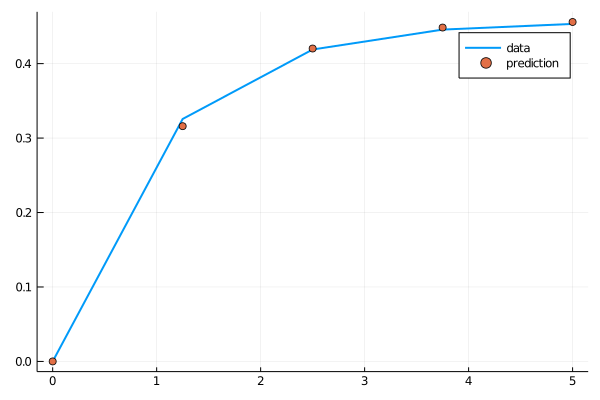

false

In [41]:
cb(res.minimizer,loss_n_ode(res.minimizer)...;doplot=true)

In [22]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, BFGS(), cb=cb, maxiters=200)

0.001823413f0

0.001808806f0

0.0017933968f0

0.0017757037f0

0.0017673013f0

0.0017567638f0

0.0017475297f0

0.0017301282f0

0.0017120269f0

0.0016760223f0

0.0016010273f0

0.0015098947f0

0.0010546242f0

0.00085541443f0

0.00079085666f0

0.0007694053f0

0.0007582127f0

0.00072580075f0

0.00061321934f0

0.00042836615f0

0.000291054f0

0.00023785347f0

0.00022712113f0

0.00022162426f0

0.00021876788f0

0.00020777402f0

0.0001463175f0

6.983068f-5

5.6421122f-5

5.321545f-5

5.2399344f-5

4.6602974f-5

1.4587644f-5

9.929237f-6

9.337643f-6

9.194689f-6

7.894227f-6

3.4061716f-6

1.9150998f-6

1.8768354f-6

1.6229316f-6

5.505344f-7

4.7655135f-7

4.696394f-7

4.13739f-7

1.2447981f-7

5.4645263f-8

5.389051f-8

1.2338078f-8

1.1221863f-8

2.4194553f-9

3.5292816f-10

9.0460375f-11

1.0112106f-11

2.562673f-12

2.4099557f-12

7.3555615f-13

3.7437384f-13

3.5527107f-13

1.2036701f-13

1.065835f-13

7.7520354f-14

7.752022f-14

6.2048484f-14

6.2048484f-14

 * Status: success

 * Candidate solution
    Minimizer: [6.16e-02, -1.08e-01, 8.37e-02,  ...]
    Minimum:   6.204848e-14

 * Found with
    Algorithm:     BFGS
    Initial Point: [6.16e-02, -1.08e-01, 8.37e-02,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.32e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   729  (vs limit Inf)
    Iterations:    64
    f(x) calls:    208
    ∇f(x) calls:   208


6.2074694f-14

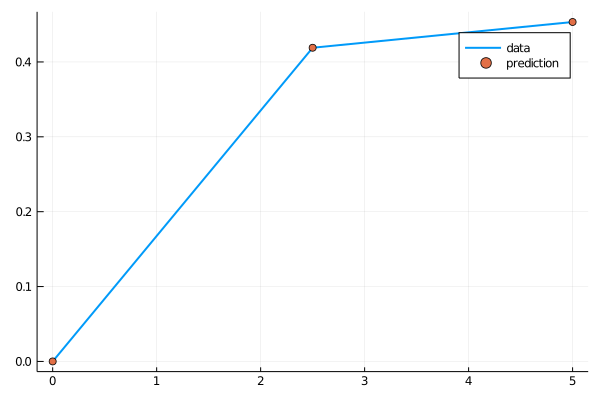

false

In [23]:
cb(res.minimizer, loss_n_ode(res.minimizer)...; doplot=true)

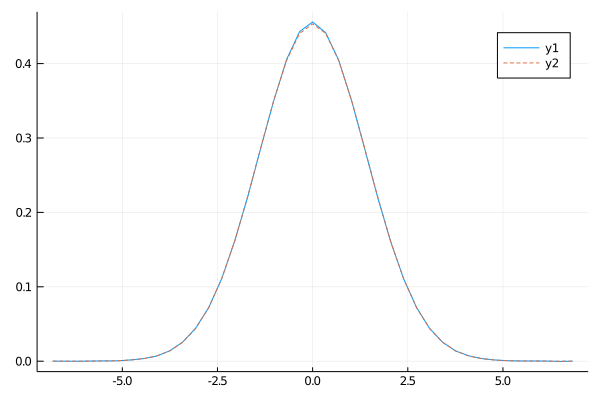

In [46]:
plot(vSpace.u, predict_n_ode(f0, res.minimizer).u[end])
plot!(vSpace.u, ode_data[:,end], line=:dash)

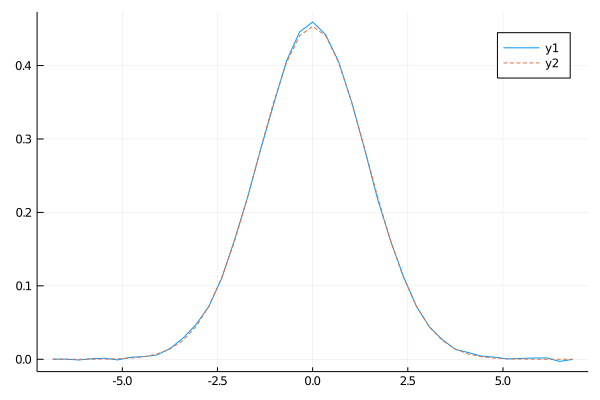

In [48]:
plot(vSpace.u, predict_n_ode((0.9 .* M .+ 0.1 .* f0), res.minimizer).u[end])
plot!(vSpace.u, ode_data[:,end], line=:dash)